In [9]:
import numpy as np

from torch_geometric.utils import to_networkx, from_networkx
import pandas as pd
import matplotlib.pyplot as plt
import time 

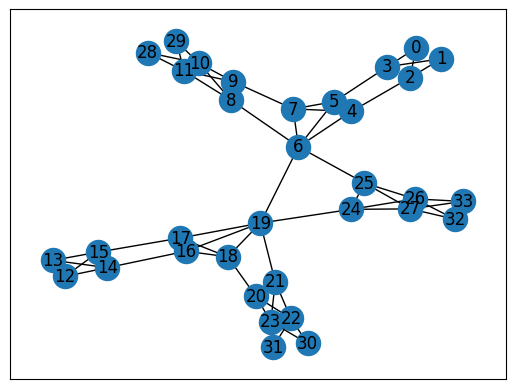

In [10]:
df = pd.read_csv('links.csv')[['DeviceA_Code','DeviceB_Code']]
points_list = [(i,j) for i,j in df.values]

import networkx as nx
G=nx.Graph()
G.add_edges_from(points_list)
pos = nx.spring_layout(G, seed=0)

seperate = True
if seperate:
    nx.draw_networkx_nodes(G,pos)
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos)
    plt.show()
else:
    #nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), with_labels=True, node_color=data.y, cmap="Set2")
    nx.draw_networks(G)
    plt.show()



In [11]:
#DP path:           [30, 22, 21, 19, 6, 4]
#dijkstra path:     [30, 22, 21, 19, 6, 4]

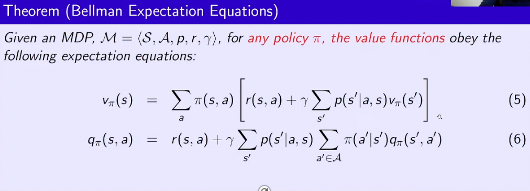
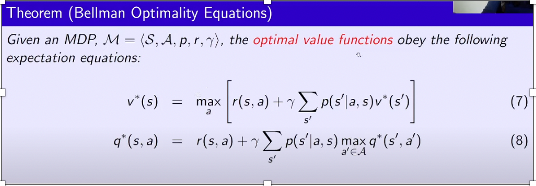


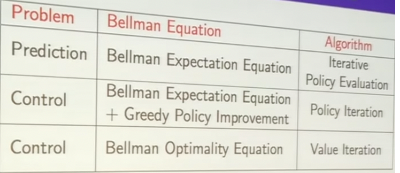
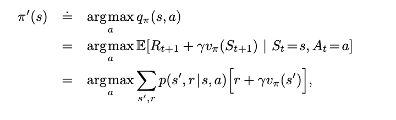

### Value Iteration

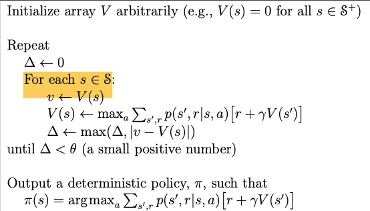

In [15]:
import importlib
import env
importlib.reload(env)
from env import *
from copy import copy

dest = 10
env = CitizenBankEnv(10)
env.costs

array([[   0.,    0., 1000., ...,    0.,    0.,    0.],
       [   0.,    0., 1000., ...,    0.,    0.,    0.],
       [1000., 1000.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

### DP Program only utlizes the costs in the env

In [16]:
import importlib
import AgentBase
importlib.reload(AgentBase)
from AgentBase import DP_PlanningBase    

planner = DP_PlanningBase(env)
start = time.time()
for dest in range(env.num_devices):
    v, p = planner.value_iteration(dest)
    for src in range(34): 
        #print('DP path:          ', planner.find_path(src, dest))
        #print('dijkstra path:    ', nx.shortest_path(G, src, dest, weight='Bandwidth (Mbps)'))
        #planner.find_path(src, dest)
        pass
print('---- total ---:', time.time() - start)


---- total ---: 0.07090473175048828


### Policy Iteration

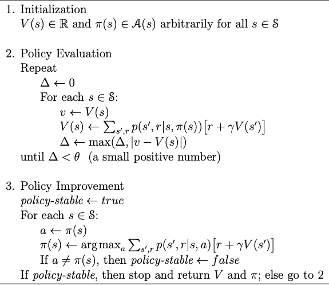

In [18]:
import importlib
import AgentBase
importlib.reload(AgentBase)
from AgentBase import DP_PlanningBase    

class PolicyIteration(DP_PlanningBase):
    def __init__(self, env, delta=0.1, alpha=0.95):
        self.env = env
        self.V = np.zeros(env.num_devices)
        self.delta = delta
        self.alpha = alpha
        self.generate_random_policy()
        self.holder = np.zeros(env.num_devices)
    
    def generate_random_policy(self):
        ################################
        #generate initial random policy
        ################################
        self.PI = np.zeros(env.num_devices).astype(int)
        for s in range(self.env.num_devices):
            actions = self.available_actions(s)
            self.PI[s] = np.random.choice(actions)
        return 
    
    def available_actions(self, s):
        actions = [i for i, j in enumerate(self.env.costs[s,]) if j > 0]
        return actions
    
    def set_costs(self, dest, value):
        ###########################################
        # re adjust the cost function for each dest
        ###########################################
        costs = copy(self.env.costs)
        for m,n in enumerate(costs[:,dest]):
            if n > 0:
                costs[m,dest] = value #make the dest have larger reward!!
        return costs
        
    def policy_improv(self, dest, value=1):
        ##################################
        # Provide the updated self.PI
        ##################################
        pi_ = copy(self.PI)
        costs = self.set_costs(dest, value)        
        
        for s in range(self.env.num_devices):
            if s != dest:
                actions = self.available_actions(s) 
                Qs = -costs[s][actions] + self.alpha*self.V[actions]    
                idx = np.argmax(Qs)
                self.PI[s] = actions[idx]
            else:
                self.PI[s] = dest
        stable =np.sum(abs(pi_ - self.PI))

        return stable
        
    def policy_eval(self, dest, value=1):
        ###########################################
        # Provide updated the self.V after each run
        ###########################################  
        diff = self.delta
        costs = self.set_costs(dest, value) 
        
        i=0
        while diff >= self.delta:
            i+=1
            for s in range(self.env.num_devices):
                v_ = copy(self.V[s])
                if s != dest:
                    self.V[s] = -costs[s,self.PI[s]] + self.alpha*self.V[self.PI[s]]  
                else:
                    self.V[s] = -costs[s,self.PI[s]]
                self.holder[s] = np.abs(v_ - self.V[s])
            diff = np.sum(self.holder)
            #print(diff)
        return 

    def policy_iteration(self, dest, value=1):
        stable = True
        
        i=0
        while stable:
            i+=1
            self.policy_eval(dest)
            stable = self.policy_improv(dest)
            if i % 1 == 0:
                #print('iterations: ', i, stable)
                pass
        return 
        
planner = PolicyIteration(env)
#planner.policy_eval(23)
#print(planner.PI)
#planner.policy_improv(23)
#print(planner.PI)
#print(planner.V)
#print(planner.PI)

#src = 13
#dest = 0
#planner.policy_iteration(dest)
#print('V: ', planner.V)
#print('PI: ', planner.PI)
#print('DP:            ', planner.find_path(src, dest))
#print('dijkstra path: ', nx.shortest_path(G, src, dest, weight='Bandwidth (Mbps)'))

start = time.time()
for dest in range(env.num_devices):
    #print('destination: ', dest)
    planner.policy_iteration(dest)
    for src in range(34): 
        #print('DP path:          ', planner.find_path(src, dest))
        #print('dijkstra path:    ', nx.shortest_path(G, src, dest, weight='Bandwidth (Mbps)'))
        #planner.find_path(src, dest)
        pass
#print('---- total ---:', time.time() - start)
